In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics, model_selection
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_excel('/content/drive/My Drive/SHRS_smallDS.xlsx',index_col=False)
print(data.shape)



(30000, 17)


In [4]:
missing_values = data.isnull().sum()

In [5]:
df_dropped = data.dropna()

In [6]:
data['Survival months'] = data['Survival months'].replace('Unknown', 0).astype(int)

In [7]:
# filter the dataset
def Survival(row):
    if (row['Survival months'] >= 60) and (row['Vital status recode (study cutoff used)'] == 'Alive'):
        return 1
    elif (row['Survival months'] < 60) and (row['SEER cause-specific death classification'] == 'Dead (attributable to this cancer dx)'):
        return 0
    else:
        data.drop(index=row.name, inplace=True)



data['Survived'] = data.apply(Survival, axis=1)
data[:5]

,Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Primary Site,Histologic Type ICD-O-3,Grade Recode (thru 2017),Marital status at diagnosis,Median household income inflation adj to 2021,Regional nodes examined (1988+),Regional nodes positive (1988+),SEER cause-specific death classification,Survival months,Vital status recode (study cutoff used),Age recode with <1 year olds,"Race recode (White, Black, Other)",Sex,Year of diagnosis,CS Tumor Size/Ext Eval (2004-2015),Survived
1,Rectum,Malignant,209,8140,Well differentiated; Grade I,Single (never married),"$75,000+",10,0,Dead (attributable to this cancer dx),49,Dead,65-69 years,White,Male,2000,Blank(s),0.0
2,Rectosigmoid Junction,Malignant,199,8140,Moderately differentiated; Grade II,Single (never married),"$75,000+",8,1,Alive or dead of other cause,155,Alive,35-39 years,White,Female,2008,3,1.0
3,Ascending Colon,Malignant,182,8140,Moderately differentiated; Grade II,Widowed,"$75,000+",14,1,Dead (attributable to this cancer dx),11,Dead,60-64 years,Black,Male,1995,Blank(s),0.0
4,Lung and Bronchus,Malignant,343,8012,Well differentiated; Grade I,Married (including common law),"$75,000+",1,1,Dead (attributable to this cancer dx),20,Dead,35-39 years,White,Female,1992,Blank(s),0.0
5,Breast,Malignant,506,8520,Moderately differentiated; Grade II,Divorced,"$75,000+",0,98,Dead (attributable to this cancer dx),14,Dead,75-79 years,White,Female,2003,Blank(s),0.0


In [8]:
import re

#get the first two interger from a string
def get_first_two_ints(s):
    numbers = re.findall(r'\d+', s)
    return [int(num) for num in numbers[:2]]

# convert to numerical form
data['Age'] = None
data['Income'] = None
data['Tumor Size'] = None
data['Grade Recode'] = None

GR = {'Unknown': 0,'Undifferentiated; anaplastic; Grade IV': 4, 'Poorly differentiated; Grade III': 3, 'Moderately differentiated; Grade II': 2, 'Well differentiated; Grade I': 1}

for index, row in data.iterrows():
    data.at[index, 'Age'] = data.at[index, 'Age recode with <1 year olds'][:2]
    data.at[index, 'Income'] = get_first_two_ints(data.at[index, 'Median household income inflation adj to 2021'])[0]
    if data.at[index, 'CS Tumor Size/Ext Eval (2004-2015)'] == 'Blank(s)':
        data.at[index, 'Tumor Size'] = 0
    else:
        data.at[index, 'Tumor Size'] = data.at[index, 'CS Tumor Size/Ext Eval (2004-2015)']
    data.at[index, 'Grade Recode'] = GR[data.at[index, 'Grade Recode (thru 2017)']]

data['Survived'] = data['Survived'].astype(int)
data['Age'] = data['Age'].astype(int)
data['Income'] = data['Income'].astype(int)
data['Tumor Size'] = data['Tumor Size'].astype(int)
data['Grade Recode'] = data['Grade Recode'].astype(int)
data

,Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Primary Site,Histologic Type ICD-O-3,Grade Recode (thru 2017),Marital status at diagnosis,Median household income inflation adj to 2021,Regional nodes examined (1988+),Regional nodes positive (1988+),SEER cause-specific death classification,...,Age recode with <1 year olds,"Race recode (White, Black, Other)",Sex,Year of diagnosis,CS Tumor Size/Ext Eval (2004-2015),Survived,Age,Income,Tumor Size,Grade Recode
1,Rectum,Malignant,209,8140,Well differentiated; Grade I,Single (never married),"$75,000+",10,0,Dead (attributable to this cancer dx),...,65-69 years,White,Male,2000,Blank(s),0,65,75,0,1
2,Rectosigmoid Junction,Malignant,199,8140,Moderately differentiated; Grade II,Single (never married),"$75,000+",8,1,Alive or dead of other cause,...,35-39 years,White,Female,2008,3,1,35,75,3,2
3,Ascending Colon,Malignant,182,8140,Moderately differentiated; Grade II,Widowed,"$75,000+",14,1,Dead (attributable to this cancer dx),...,60-64 years,Black,Male,1995,Blank(s),0,60,75,0,2
4,Lung and Bronchus,Malignant,343,8012,Well differentiated; Grade I,Married (including common law),"$75,000+",1,1,Dead (attributable to this cancer dx),...,35-39 years,White,Female,1992,Blank(s),0,35,75,0,1
5,Breast,Malignant,506,8520,Moderately differentiated; Grade II,Divorced,"$75,000+",0,98,Dead (attributable to this cancer dx),...,75-79 years,White,Female,2003,Blank(s),0,75,75,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,Lung and Bronchus,Malignant,342,8041,Undifferentiated; anaplastic; Grade IV,Divorced,"$70,000 - $74,999",0,98,Dead (attributable to this cancer dx),...,55-59 years,White,Female,1991,Blank(s),0,55,70,0,4
29995,Gallbladder,Malignant,239,8140,Unknown,Divorced,"$70,000 - $74,999",0,98,Dead (attributable to this cancer dx),...,70-74 years,White,Female,1990,Blank(s),0,70,70,0,0
29997,Lung and Bronchus,Malignant,349,8140,Poorly differentiated; Grade III,Single (never married),"$70,000 - $74,999",0,98,Dead (attributable to this cancer dx),...,65-69 years,Black,Male,1991,Blank(s),0,65,70,0,3
29998,Lung and Bronchus,Malignant,341,8012,Unknown,Married (including common law),"$75,000+",0,98,Dead (attributable to this cancer dx),...,75-79 years,White,Male,1991,Blank(s),0,75,75,0,0


In [9]:
# Initialize a dictionary to store the mappings
category_mappings = {}

# Manually encode each categorical column to numerical values
for column in data.select_dtypes(include=['object']):
    # Create a mapping for the current column
    categories = data[column].unique()
    mapping = {category: index for index, category in enumerate(categories)}
    category_mappings[column] = mapping

    # Replace the categorical values with numerical values
    data[column] = data[column].replace(mapping)

print("Encoded DataFrame:")
print(data)

print("\nCategory Mappings:")
for column, mapping in category_mappings.items():
    print(f"{column}: {mapping}")

Encoded DataFrame:
       Site recode ICD-O-3/WHO 2008  Behavior code ICD-O-3  Primary Site  \
1                                 0                      0           209   
2                                 1                      0           199   
3                                 2                      0           182   
4                                 3                      0           343   
5                                 4                      0           506   
...                             ...                    ...           ...   
29993                             3                      0           342   
29995                             9                      0           239   
29997                             3                      0           349   
29998                             3                      0           341   
29999                             6                      0           549   

       Histologic Type ICD-O-3  Grade Recode (thru 2017)  \
1       

In [10]:
data

,Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Primary Site,Histologic Type ICD-O-3,Grade Recode (thru 2017),Marital status at diagnosis,Median household income inflation adj to 2021,Regional nodes examined (1988+),Regional nodes positive (1988+),SEER cause-specific death classification,...,Age recode with <1 year olds,"Race recode (White, Black, Other)",Sex,Year of diagnosis,CS Tumor Size/Ext Eval (2004-2015),Survived,Age,Income,Tumor Size,Grade Recode
1,0,0,209,8140,0,0,0,10,0,0,...,0,0,0,2000,0,0,65,75,0,1
2,1,0,199,8140,1,0,0,8,1,1,...,1,0,1,2008,1,1,35,75,3,2
3,2,0,182,8140,1,1,0,14,1,0,...,2,1,0,1995,0,0,60,75,0,2
4,3,0,343,8012,0,2,0,1,1,0,...,1,0,1,1992,0,0,35,75,0,1
5,4,0,506,8520,1,3,0,0,98,0,...,3,0,1,2003,0,0,75,75,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,3,0,342,8041,4,3,1,0,98,0,...,4,0,1,1991,0,0,55,70,0,4
29995,9,0,239,8140,2,3,1,0,98,0,...,7,0,1,1990,0,0,70,70,0,0
29997,3,0,349,8140,3,0,1,0,98,0,...,0,1,0,1991,0,0,65,70,0,3
29998,3,0,341,8012,2,2,0,0,98,0,...,3,0,0,1991,0,0,75,75,0,0


In [11]:
# make a new data frame and store the useful attributes
final = data[['Site recode ICD-O-3/WHO 2008','Race recode (White, Black, Other)',
           'Sex',
           'Histologic Type ICD-O-3',
           'Regional nodes examined (1988+)',
           'Regional nodes positive (1988+)',
           'Primary Site',
           'Marital status at diagnosis',
           'Survived',
           'Age',
           'Income',
           'Tumor Size',
           'Grade Recode']]
final

,Site recode ICD-O-3/WHO 2008,"Race recode (White, Black, Other)",Sex,Histologic Type ICD-O-3,Regional nodes examined (1988+),Regional nodes positive (1988+),Primary Site,Marital status at diagnosis,Survived,Age,Income,Tumor Size,Grade Recode
1,0,0,0,8140,10,0,209,0,0,65,75,0,1
2,1,0,1,8140,8,1,199,0,1,35,75,3,2
3,2,1,0,8140,14,1,182,1,0,60,75,0,2
4,3,0,1,8012,1,1,343,2,0,35,75,0,1
5,4,0,1,8520,0,98,506,3,0,75,75,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,3,0,1,8041,0,98,342,3,0,55,70,0,4
29995,9,0,1,8140,0,98,239,3,0,70,70,0,0
29997,3,1,0,8140,0,98,349,0,0,65,70,0,3
29998,3,0,0,8012,0,98,341,2,0,75,75,0,0


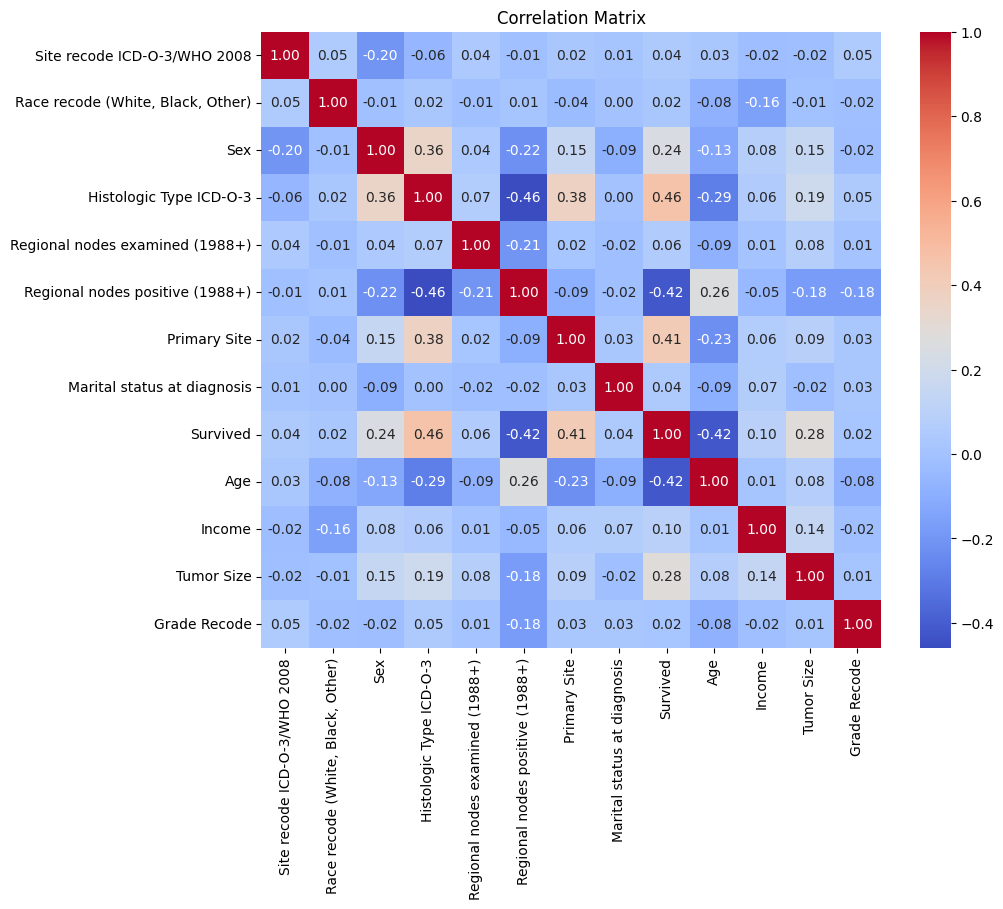

In [12]:
correlation_matrix = final.corr()
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title (optional)
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [13]:
X = final.drop('Survived', axis='columns')
X

,Site recode ICD-O-3/WHO 2008,"Race recode (White, Black, Other)",Sex,Histologic Type ICD-O-3,Regional nodes examined (1988+),Regional nodes positive (1988+),Primary Site,Marital status at diagnosis,Age,Income,Tumor Size,Grade Recode
1,0,0,0,8140,10,0,209,0,65,75,0,1
2,1,0,1,8140,8,1,199,0,35,75,3,2
3,2,1,0,8140,14,1,182,1,60,75,0,2
4,3,0,1,8012,1,1,343,2,35,75,0,1
5,4,0,1,8520,0,98,506,3,75,75,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29993,3,0,1,8041,0,98,342,3,55,70,0,4
29995,9,0,1,8140,0,98,239,3,70,70,0,0
29997,3,1,0,8140,0,98,349,0,65,70,0,3
29998,3,0,0,8012,0,98,341,2,75,75,0,0


In [14]:
y = final['Survived']
y

1        0
2        1
3        0
4        0
5        0
        ..
29993    0
29995    0
29997    0
29998    0
29999    0
Name: Survived, Length: 14641, dtype: int64

In [15]:
sensitive_features_df = final[['Sex', 'Marital status at diagnosis', 'Race recode (White, Black, Other)', 'Income']]


In [16]:

# Assuming X and y are your features and labels, and sensitive_features is a DataFrame or Series of your sensitive features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_train, sensitive_test = train_test_split(sensitive_features_df, test_size=0.2, random_state=42)

In [17]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (11712, 12)
y_train shape: (11712,)
X_test shape: (2929, 12)
y_test shape: (2929,)


In [18]:
pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 25.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvi

In [19]:
from fairlearn.metrics import MetricFrame


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, sensitive_features_train, sensitive_features_test = train_test_split(
    X, y, sensitive_features_df, test_size=0.2, random_state=42
)

# Train the unmitigated AdaBoost model
unmitigated_model = AdaBoostClassifier().fit(X_train, y_train)
y_pred_unmitigated = unmitigated_model.predict(X_test)

# Assess fairness of the unmitigated model
metric_frame_unmitigated = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'selection_rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred_unmitigated,
    sensitive_features=sensitive_features_test
)

# Define and fit the mitigated model using ExponentiatedGradient and EqualizedOdds
mitigator = ExponentiatedGradient(
    estimator=AdaBoostClassifier(),
    constraints=EqualizedOdds()
)

mitigated_model = mitigator.fit(
    X_train, y_train,
    sensitive_features=sensitive_features_train
)

# Predict with the mitigated model
y_pred_mitigated = mitigated_model.predict(X_test)

# Assess fairness of the mitigated model
metric_frame_mitigated = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'selection_rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_features_test
)

# Print metrics for both models
print("Unmitigated AdaBoost model metrics:")
print(metric_frame_unmitigated.by_group)

print("Mitigated AdaBoost model metrics:")
print(metric_frame_mitigated.by_group)

Unmitigated AdaBoost model metrics:
                                                                          accuracy  \
Sex Marital status at diagnosis Race recode (White, Black, Other) Income             
0   0                           0                                 70      0.964286   
                                                                  75      0.923077   
                                1                                 70      0.875000   
                                                                  75      0.956522   
                                2                                 70      1.000000   
                                                                  75      0.800000   
    1                           0                                 70      1.000000   
                                                                  75      0.989011   
                                1                                 70      1.000000   
                  

In [22]:
# Use MetricFrame to assess fairness of the unmitigated model by sensitive feature
group_metrics_unmitigated = {}
for feature in sensitive_features_test.columns:
    metric_frame = MetricFrame(
        metrics={'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'selection_rate': selection_rate},
        y_true=y_test,
        y_pred=y_pred_unmitigated,
        sensitive_features=sensitive_features_test[feature]
    )
    group_metrics_unmitigated[feature] = metric_frame.by_group

# Use MetricFrame to assess fairness of the mitigated model by sensitive feature
group_metrics_mitigated = {}
for feature in sensitive_features_test.columns:
    metric_frame = MetricFrame(
        metrics={'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'selection_rate': selection_rate},
        y_true=y_test,
        y_pred=y_pred_mitigated,
        sensitive_features=sensitive_features_test[feature]
    )
    group_metrics_mitigated[feature] = metric_frame.by_group

# Print the metrics for each group in the unmitigated model
print("Unmitigated model group-wise metrics:")
for feature, metrics in group_metrics_unmitigated.items():
    print(f"\nMetrics for '{feature}':")
    print(metrics)

# Print the metrics for each group in the mitigated model
print("\nMitigated model group-wise metrics:")
for feature, metrics in group_metrics_mitigated.items():
    print(f"\nMetrics for '{feature}':")
    print(metrics)

Unmitigated model group-wise metrics:

Metrics for 'Sex':
     accuracy  precision    recall  selection_rate
Sex                                               
0    0.934555   0.827273  0.619048        0.095986
1    0.883904   0.820168  0.829932        0.333707

Metrics for 'Marital status at diagnosis':
                             accuracy  precision    recall  selection_rate
Marital status at diagnosis                                               
0                            0.880000   0.775862  0.803571        0.290000
1                            0.952846   0.812500  0.661017        0.078049
2                            0.890783   0.836910  0.800821        0.294192
3                            0.904605   0.814286  0.780822        0.230263
4                            0.884615   0.600000  0.750000        0.192308

Metrics for 'Race recode (White, Black, Other)':
                                   accuracy  precision    recall  \
Race recode (White, Black, Other)                  

In [23]:

# Now add selection_rate to the metrics dictionary
metrics_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}

# Assess fairness of the unmitigated model with selection_rate included
metric_frame_unmitigated = MetricFrame(
    metrics=metrics_dict,
    y_true=y_test,
    y_pred=y_pred_unmitigated,
    sensitive_features=sensitive_test
)

# Assess fairness of the mitigated model with selection_rate included
metric_frame_mitigated = MetricFrame(
    metrics=metrics_dict,
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_test
)


# Create summary DataFrames for the unmitigated and mitigated models
summary_df_unmitigated = pd.DataFrame()
summary_df_mitigated = pd.DataFrame()

for feature_name in sensitive_test.columns:
    summary_df_unmitigated[feature_name] = metric_frame_unmitigated.by_group.mean()
    summary_df_mitigated[feature_name] = metric_frame_mitigated.by_group.mean()

# Combine the summaries into a single DataFrame for comparison
summary_df = pd.concat([summary_df_unmitigated.add_suffix('_unmitigated'),
                        summary_df_mitigated.add_suffix('_mitigated')], axis=1)

# Transpose the DataFrame so that each row represents a sensitive feature
summary_df = summary_df.T

# Print the summary DataFrame
print(summary_df)

                                               accuracy  precision    recall  \
Sex_unmitigated                                0.906236   0.508049  0.462977   
Marital status at diagnosis_unmitigated        0.906236   0.508049  0.462977   
Race recode (White, Black, Other)_unmitigated  0.906236   0.508049  0.462977   
Income_unmitigated                             0.906236   0.508049  0.462977   
Sex_mitigated                                  0.761334   0.255052  0.259246   
Marital status at diagnosis_mitigated          0.761334   0.255052  0.259246   
Race recode (White, Black, Other)_mitigated    0.761334   0.255052  0.259246   
Income_mitigated                               0.761334   0.255052  0.259246   

                                               selection_rate  
Sex_unmitigated                                      0.161792  
Marital status at diagnosis_unmitigated              0.161792  
Race recode (White, Black, Other)_unmitigated        0.161792  
Income_unmitigated     

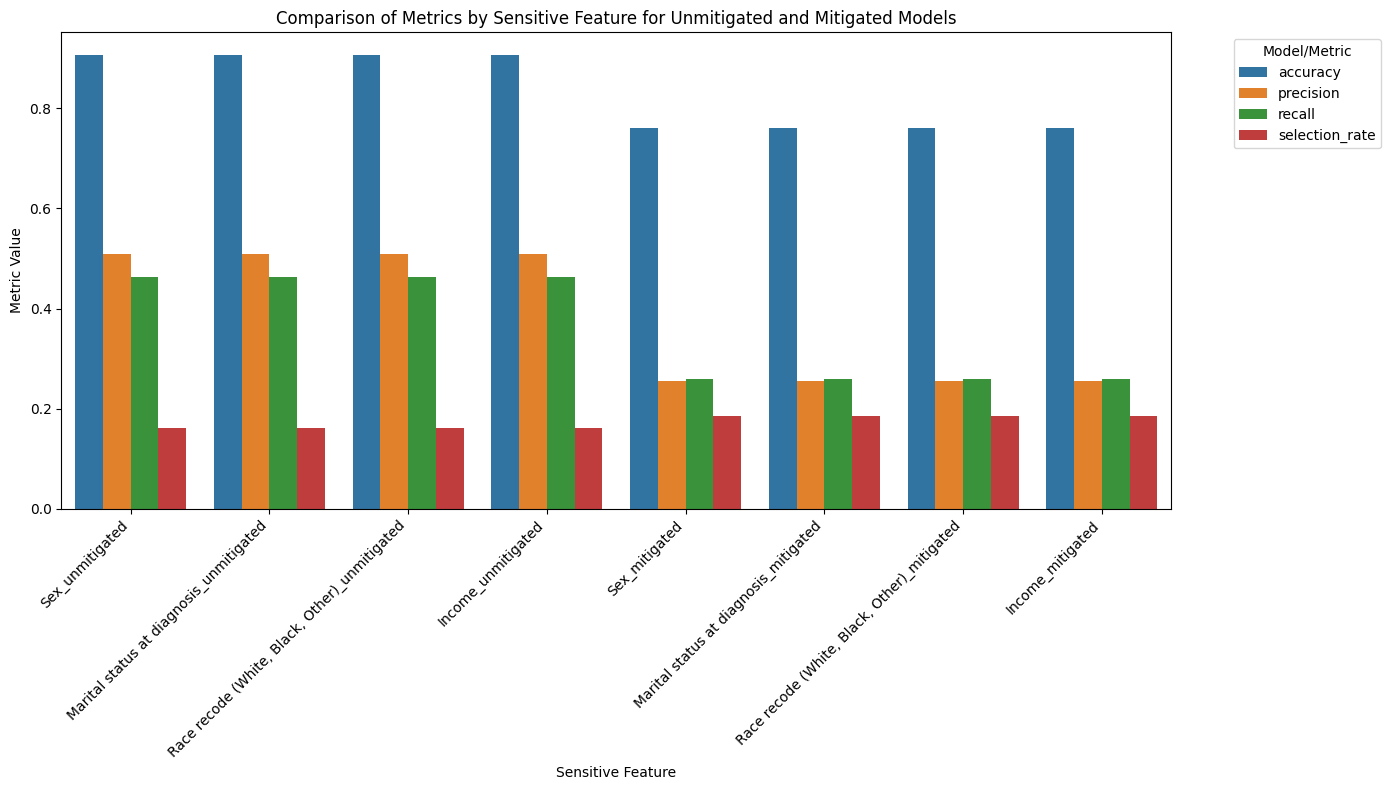

In [24]:


# Assuming summary_df is already created as per the previous code snippet

# Since we transposed the summary DataFrame, each column represents a metric for the unmitigated/mitigated model,
# and each row represents a sensitive feature.

# Reset index to use default integer index and turn 'index' into a column for plotting
summary_df_reset = summary_df.reset_index()

# Melt the DataFrame to long-format for seaborn to plot
summary_df_melted = summary_df_reset.melt(id_vars='index', var_name='Model_Metric', value_name='Value')

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=summary_df_melted, x='index', y='Value', hue='Model_Metric')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Sensitive Feature')
plt.ylabel('Metric Value')
plt.title('Comparison of Metrics by Sensitive Feature for Unmitigated and Mitigated Models')
plt.legend(title='Model/Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()